### Stacking Variational Bayesian Monte Carlo (S-VBMC)

This notebook shows the usage of the `SVBMC` class to stack posteriors from different Variational Bayesian Monte Carlo (VBMC) runs, optimising the ELBO of the resulting stacked posterior ($\text{ELBO}_{\text{stacked}}$). This is useful when separate VBMC runs give different results, i.e. when VBMC discovers different portions of the posterior in different runs.

Let's start with imports. 

In [1]:
import pickle
from svbmc import SVBMC
from visualisation import overlay_corner_plot # plots overlayed distributions from samples
import numpy as np


#### Example 1: Multimodal target

One situation in which VBMC is likely to yield suboptimal results is when the target distribution has multiple, distant modes. We use this as our first example, showcasing how, while VBMC tends to get stuck overexploring the parameter region around an individual mode, stacking different (randomly initialised) runs manages to cature the full distribution effectively.

Let's start by plotting our target using samples taken directly from it.


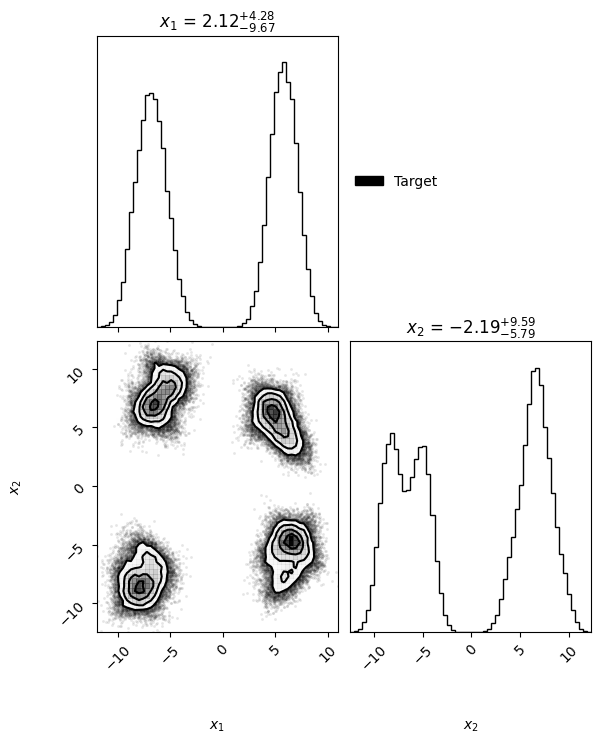

In [2]:
X_gmm_gt = np.loadtxt("samples/gmm_D_2_GT.csv", # path to file
                    delimiter=",", # CSV uses commas
                    dtype=float)            
                         
_ = overlay_corner_plot(
    [X_gmm_gt], # list of samples, just one in this case
    label = ["Target"], # label for legend
    color = ["black"], # colour for plot
    base = 4, # make it a bit bigger since it's only 2D
    bins = 60
    )

Now let's load a few `vp` objects output from different VBMC runs (see https://github.com/acerbilab/pyvbmc/tree/main for details). 

In [3]:
# Load variational posteriors
vp_list_gmm = []

for i in range(10):
    # Provide the path to your .pkl file
    file_path = f'vbmc_runs/GMM/vp_gmm_try_{i}.pkl' # Change if necessary

    with open(file_path, 'rb') as file:
        vp_list_gmm.append(pickle.load(file))

Let's plot a couple of posteriors (overlayed with the ground truth) to see how VBMC did.

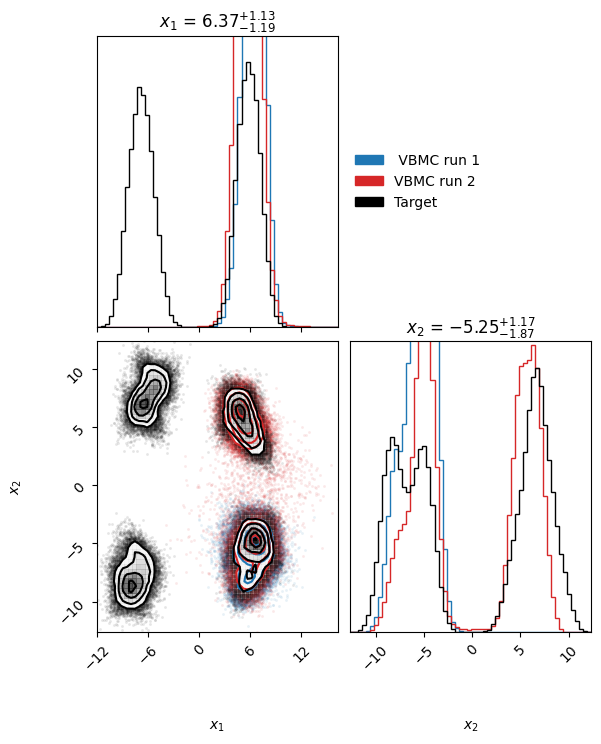

In [4]:
# Take samples
vbmc_samples_gmm = []

for m in range(2):
    Xs, _ = vp_list_gmm[m].sample(X_gmm_gt.shape[0]) # same number of samples as the ground truth
    vbmc_samples_gmm.append(Xs)

# Plot
_ = overlay_corner_plot(vbmc_samples_gmm + [X_gmm_gt], 
                        label = [" VBMC run 1", "VBMC run 2", "Target"], 
                        color = ["tab:blue", "tab:red", "black"], 
                        base=4, 
                        bins=60)

We can see that in both cases VBMC has missed some high mass probability regions, remaining stuck on one (or two) modes. 

Let's see if S-VBMC can fix this. Given a list of vp object obtained by running VBMC multiple times (here `vp_list`), our approach can be implelmented in a few lines of code.

__NOTE__: One should only use properly converged VBMC runs as input for S-VBMC. Luckily, PyVBMC (https://github.com/acerbilab/pyvbmc/tree/main) offers good diagnostic tools to determine this, so it's easy to set up a filter. We found that filtering out runs not marked as "stable" and with excessive uncertainty in the estimation of the expected log-joint under individual components (see paper for details) works well. 

In [5]:
# Filtering out bad runs, if present
before_filter = len(vp_list_gmm) 
vp_list_gmm = [vp for vp in vp_list_gmm if (vp.stats['stable'] and np.max(vp.stats['J_sjk']) < 5)]
after_filter = len(vp_list_gmm) 
print(f"{before_filter-after_filter} bad runs removed \n\n")

# Initialise SVBMC object
vp_stacked_gmm = SVBMC(vp_list=vp_list_gmm)

# Optimise stacked ELBO
vp_stacked_gmm.optimize()

print(f'Stacked ELBO: {vp_stacked_gmm.elbo["estimated"]}') # The target is noiseless, so there is no need for debiasing

0 bad runs removed 


Optimising the stacked ELBO w.r.t. all weights
Initial elbo = 2.979610366297538
iter 5: elbo = 2.9921723876552333
iter 10: elbo = 2.9933050791129006
Stacked ELBO: 3.024067945430268


Let's visualise the stacked posterior and see how it compares to the ground truth.


__IMPORTANT NOTE__: 

__DO NOT__ try to make plots or evaluate metrics using the sufficient statistics of the stacked posterior. The means and standard deviations of the stacked posterior's Gaussian compoents are expressed in different feature spaces, as VBMC applies different parameter transformations in each run. Therefore, you should __ALWAYS USE SAMPLES__. These can be obtained with the `sample` method from a `SVBMC` object, and are expressed in the original parameter space.

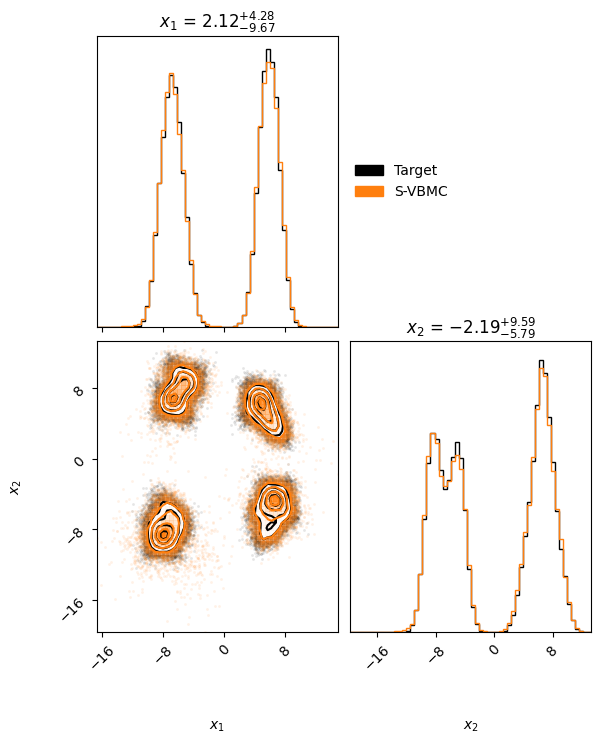

In [6]:
# Take samples from stacked posterior
svbmc_samples_gmm = vp_stacked_gmm.sample(X_gmm_gt.shape[0])

_ = overlay_corner_plot(
        samples = [X_gmm_gt, svbmc_samples_gmm], 
        label = ["Target", "S-VBMC"], 
        color = ["black", "tab:orange"], 
        base = 4, 
        bins = 60
        )

The stacked posterior should now cover all four modes, showing a very good match with the ground truth. Let's now try another example.

#### Example 2: Ring target

Another situation in which VBMC is likely to perform poorly is when the target distribution is long and slim. Here we use a ring-shaped target, let' have a look at it. Here we use samples obtained with MCMC as the ground truth.


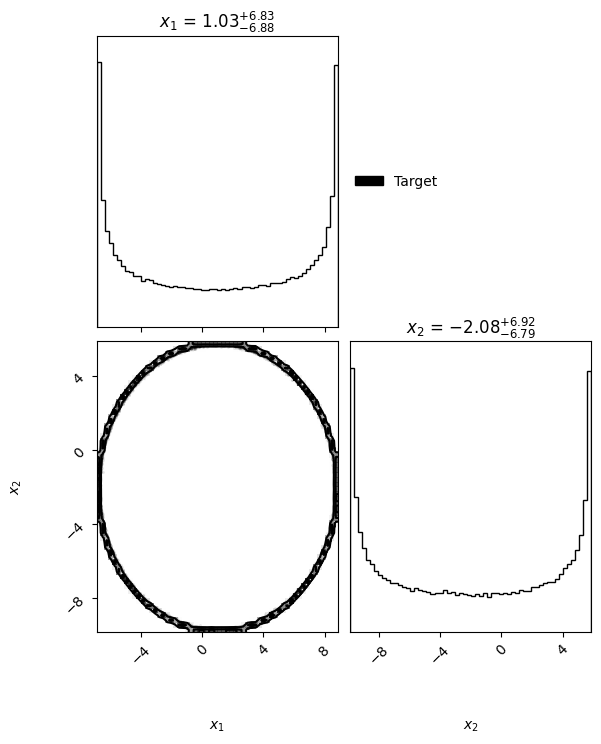

In [7]:
X_ring_gt = np.loadtxt("samples/ring_D_2_GT.csv", # path to file
                    delimiter=",", # CSV uses commas
                    dtype=float)            
                         
_ = overlay_corner_plot(
    [X_ring_gt], # list of samples, just one in this case
    label = ["Target"], # label for legend
    color = ["black"], # colour for plot
    base = 4, # make it a bit bigger since it's only 2D
    bins = 60
    )

As before, let's have a look at VBMC results.

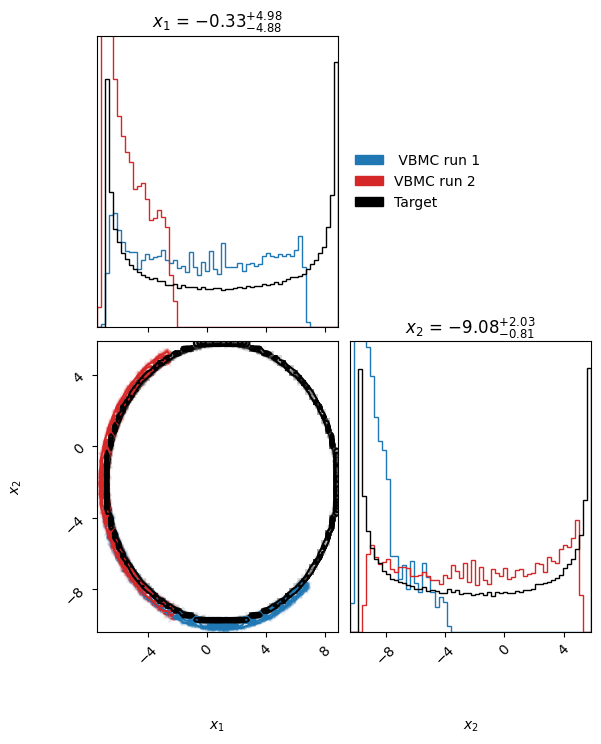

In [8]:
# Load variational posteriors
vp_list_ring = []

for i in range(10):
    # Provide the path to your .pkl file
    file_path = f'vbmc_runs/Ring/vp_ring_try_{i}.pkl' # Change if necessary

    with open(file_path, 'rb') as file:
        vp_list_ring.append(pickle.load(file))


# Take samples
vbmc_samples_ring = []

for m in range (2):
    Xs, _ = vp_list_ring[m].sample(X_ring_gt.shape[0]) # same number of samples as the ground truth
    vbmc_samples_ring.append(Xs)

# Plot
_ = overlay_corner_plot(samples = vbmc_samples_ring + [X_ring_gt], 
                        label = [" VBMC run 1", "VBMC run 2", "Target"], 
                        color = ["tab:blue", "tab:red", "black"], 
                        base=4, 
                        bins=60 
                        )

Again, VBMC fails to explore the whole posterior. Let's see if S-VBMC improves things.

0 bad runs removed 


Optimising the stacked ELBO w.r.t. all weights
Initial elbo = 2.2023427182947257
iter 5: elbo = 2.2632271815762213
iter 10: elbo = 2.2957728695358677
iter 15: elbo = 2.2916569710381314
Stacked ELBO: 2.2957728695358677


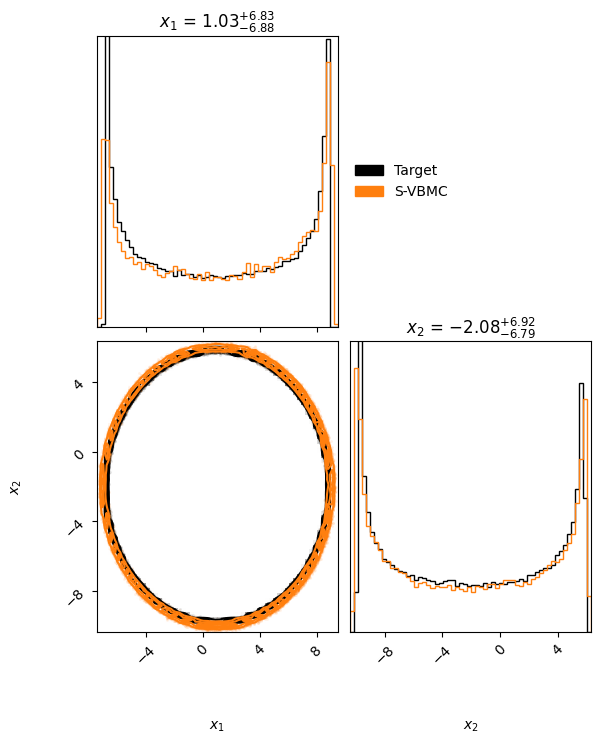

In [9]:
# Filtering out bad runs, if present
before_filter = len(vp_list_ring) 
vp_list_ring = [vp for vp in vp_list_ring if (vp.stats['stable'] and np.max(vp.stats['J_sjk']) < 5)]
after_filter = len(vp_list_ring) 
print(f"{before_filter-after_filter} bad runs removed \n\n")

# Initialise SVBMC object
vp_stacked_ring = SVBMC(vp_list=vp_list_ring)

# Optimise stacked ELBO
vp_stacked_ring.optimize()

print(f'Stacked ELBO: {vp_stacked_ring.elbo["estimated"]}')

# Take samples from stacked posterior
svbmc_samples_ring = vp_stacked_ring.sample(X_ring_gt.shape[0])

_ = overlay_corner_plot(
        samples = [X_ring_gt, svbmc_samples_ring], 
        label = ["Target", "S-VBMC"], 
        color = ["black", "tab:orange"], 
        base = 4, 
        bins = 60
        )

As before, S-VBMC effectively combined VBMC posteriors into an accurate global approximation of the true target.